In [2]:
import math
import json
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
import numpy as np
import sys
sys.path.append("/Users/mklukas/nta/htmresearch/")

from htmresearch.support.cans.reanchoring import *
from htmresearch.support.cans.basic_dynamics import *
%load_ext autoreload
%autoreload 2




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


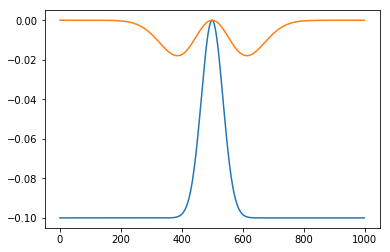

In [46]:
x = np.linspace(-10,10,num=1000)


def can_beanie(x, a=0.1, b=0.1, sigma=1.):

    lambda_net = 4.0
    beta       = 3.0 / lambda_net**2
    gamma      = 1.05 * beta
    
    x_length_squared = x**2
    
    return a*np.exp(-sigma*x_length_squared) - b

f = can_beanie(x)
g = W_zero(x)
plt.plot(f)
plt.plot(g)

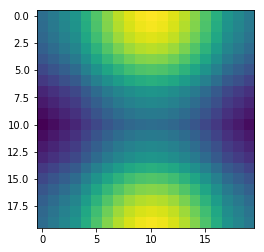

In [81]:
n=20
d=2.
X = np.mgrid[0:d:d/n, 0:d:d/n].reshape(2,-1).T



V = {
    "N"  : np.array([ 0.,  1.]),
    "W"  : np.array([-1.,  0.]),
    "S"  : np.array([ 0., -1.]),
    "E"  : np.array([ 1.,  0.])
}
W = {}


for key, val in V.iteritems():
    D = X.reshape((1,-1,2)) - (X.reshape((-1,1,2)) - val*.3)
    D = np.absolute(D)
    D = np.minimum(d - D, D)
    D = np.linalg.norm(D, axis=2)
    
#     W[key] = can_beanie(D, b=0.03, sigma=5.)
    W[key] = can_beanie(D)
    
D = X.reshape((1,-1,2)) - (X.reshape((-1,1,2)) )
D = np.absolute(D)
D = np.minimum(d - D, D)
D = np.linalg.norm(D, axis=2)
W["inh"] = can_beanie(D)
# np.fill_diagonal(W["inh"], 0.)

i=10
plt.imshow((W["N"][i] + W["W"][i] + W["S"][i] + W["E"][i]).reshape((n,n)) )

In [85]:

def evolve_step(W, b, s, dt=0.05, tau=3., f=relu):
    Ws = np.dot(W,s)
    ds  = ( f(  b ) - s/tau )*dt
    s_ = s + ds
            
    return s_

def path_integrate(Ws, s, v, theta):
    b = np.zeros(s.shape)
    R = np.array([[np.cos(-theta) , - np.sin(-theta)],
                  [np.sin(-theta) ,   np.cos(-theta)]])
    
    v_can = np.dot(R, v)
    
    for key, pd in V.iteritems():

        b += np.dot(W[key], s)*(1. + np.maximum(np.dot(v_can, pd), 0.))
        
    return b
    

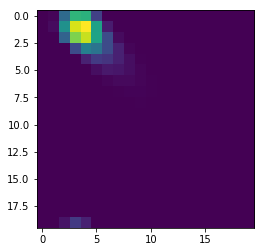

In [90]:


# plt.imshow(W[290].reshape((n,n)))
# plt.show()
# plt.plot(W[290])
# plt.show()
T = 1000
B= np.ones(T)*.1


S = np.zeros((T,n**2))
S[0] = np.random.sample(n**2)*0.1


v = np.array([4.,4.])
fig = plt.figure()
ims = []
for t in range(1, T):
    tonic = 0.05
    
    if t > 500:
        v = np.array([4.,4.])
        tonic = 0.5
    else:
        v = np.array([0.,0.])
    
    vel = path_integrate(W, S[t-1], v, np.pi)
    b = tonic + vel 
    S[t] = evolve_step(W["inh"],b,S[t-1])
    if t > 450:
        im = plt.imshow(S[t].reshape((n,n)), animated=True)
        ims.append([im])
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=20)

ani.save('dynamic_images.mp4')


# plt.imshow(W[0].reshape((n,n)))
# plt.show()

# plt.imshow(S[-1].reshape((n,n)))
# plt.show()
# plt.plot(S[-1])


# plt.imshow(S[400].reshape((n,n)))


2.991420107030693e-11
0.2909748909429232


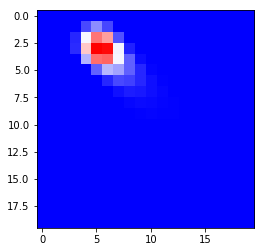

In [91]:
print np.amin(S)
print np.amax(S[-100])

plt.imshow(S[-100].reshape((n,n)), cmap="bwr")
plt.show()